In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

### Outline

The code is organized as follows. First section is the main code that will
generate matchings for different solutions. The second section gives
configuration parameters for the simulation. The third section generates
dataframes to output the latex table of results, and the heatmap.

Note that a random seed O is set.

### Main code

In [6]:
class Agent:
    def __init__(self, abo, size):
        self.abo = abo
        self.size = size

    def size_compatible(self, other):
        return self.size >= other.size

    def abo_compatible(self, other):
        if self.abo == "O":
            return True
        elif self.abo == "A":
            return other.abo in ["A", "AB"]
        elif self.abo == "B":
            return other.abo in ["B", "AB"]
        elif self.abo == "AB":
            return other.abo == "AB"
        return False

class Pair:
    def __init__(self, donor, patient, liver_willing):
        self.donor = donor
        self.patient = patient
        self.liver_willing = liver_willing

    def can_donate_to(self, other):
        pass
    
    def mutually_compatible(self, other):
        compat = self.can_donate_to(other) and other.can_donate_to(self)
        if not compat:
            return False
        if isinstance(self, LiverPair) and isinstance(other, KidneyPair):
            if not other.liver_willing:
                return False
        if isinstance(other, LiverPair) and isinstance(self, KidneyPair):
            if not self.liver_willing:
                return False
        return True

class KidneyPair(Pair):
    def can_donate_to(self, other):
        return self.donor.abo_compatible(other.patient)
    
    
class LiverPair(Pair):
    def can_donate_to(self, other):
        return self.donor.abo_compatible(other.patient) and self.donor.size_compatible(other.patient)
    
class CompatibilityGraph:
    def __init__(self, pairs_dict):
        self.pairs_dict = pairs_dict
        self.ids = list(pairs_dict.keys())
        self.G = nx.Graph()
        self.G.add_nodes_from(self.ids)
        for i in self.ids:
            for j in self.ids:
                pair, other = self.pairs_dict[i], self.pairs_dict[j]
                if i != j and pair.mutually_compatible(other):
                    self.G.add_edge(i, j)

    def max_matching(self):
        matching = nx.max_weight_matching(self.G, maxcardinality=True)
        return matching
    
    def remove_nodes(self, ids):
        self.G.remove_nodes_from(ids)

class BipartiteCompatibilityGraph:
    def __init__(self, kidney_pairs_dict, liver_pairs_dict):
        self.kidney_pairs_dict = kidney_pairs_dict
        self.liver_pairs_dict = liver_pairs_dict
        self.kidney_ids = list(kidney_pairs_dict.keys())
        self.liver_ids = list(liver_pairs_dict.keys())
        self.G = nx.Graph()
        self.G.add_nodes_from(self.kidney_ids, bipartite=0)
        self.G.add_nodes_from(self.liver_ids, bipartite=1)
        for i in self.kidney_ids:
            for j in self.liver_ids:
                kidney_pair, liver_pair = self.kidney_pairs_dict[i], self.liver_pairs_dict[j]
                if kidney_pair.mutually_compatible(liver_pair):
                    self.G.add_edge(i, j)

    def max_matching(self):
        matching = nx.max_weight_matching(self.G)
        return matching

    def remove_nodes(self, ids):
        self.G.remove_nodes_from(ids)

class AgentGenerator:
    def __init__(self, config):
        self.abos = config["abos"]
        self.sizes = config["sizes"]

    def generate_agent(self):
        return Agent(np.random.choice(self.abos), np.random.choice(self.sizes))
    
class KoreanAgentGenerator:
    def __init__(self, config):
        self.abos = ["O", "A", "B", "AB"]
        self.mean_sizes = config["mean_sizes"]
        self.std_sizes = config["std_sizes"]
        self.gender_probs = config["gender_probs"]
        self.abo_probs = config["abo_probs"]

    def generate_agent(self):
        a_m, b_m = 26.58, 1.92
        a_f, b_f = 32.79, 1.45
        abo = np.random.choice(self.abos, p=self.abo_probs)
        gender = np.random.choice(["M", "F"], p=self.gender_probs)
        if gender == "M":
            h = np.random.normal(self.mean_sizes["M"], self.std_sizes["M"])
            size = a_m * (h**b_m)
        else:
            h = np.random.normal(self.mean_sizes["F"], self.std_sizes["F"])
            size = a_f * (h**b_f)

        return Agent(abo, size)
    
class PairGenerator:
    def __init__(self, agent_generator, OrganPair, willing_prob):
        self.agent_generator = agent_generator
        self.OrganPair = OrganPair
        self.willing_prob = willing_prob

    def generate_pair(self):
        donor = self.agent_generator.generate_agent()
        patient = self.agent_generator.generate_agent()
        willing = np.random.rand() < self.willing_prob
        pair = self.OrganPair(donor, patient, willing)
        return pair
    
    def generate_incompatible_pair(self):
        pair = self.generate_pair()
        while pair.can_donate_to(pair):
            pair = self.generate_pair()
        return pair
    
    def generate_incompatible_pairs(self, n):
        pairs = []
        for i in range(n):
            pairs.append(self.generate_incompatible_pair())
        return pairs
    
def check_matching_valid(matching, pairs_dict):
    for pair_ids in matching:
        if pair_ids[0] == pair_ids[1]:
            print(f"Compatible matching: {pair}")
            return False
        pair, other = pairs_dict[pair_ids[0]], pairs_dict[pair_ids[1]]
        if not pair.mutually_compatible(other):
            donor_0 = pair.donor.abo, pair.donor.size
            patient_0 = pair.patient.abo, pair.patient.size
            donor_1 = other.donor.abo, other.donor.size
            patient_1 = other.patient.abo, other.patient.size
            print(f"Invalid matching: {pair_ids[0]} and {pair_ids[1]}")
            print("Donor Patient pairs:")
            print(f"Pair 0: {donor_0}, {patient_0}")
            print(f"Pair 1: {donor_1}, {patient_1}")
            print(f"Pair 0 compatible with Pair 1: {pair.compatible(other)}")
            print(f"Pair 1 compatible with Pair 0: {other.compatible(pair)}")
            return False
    return True
    
def count(matching, kidney_ids, liver_ids):
    kidney_matching = 0
    liver_matching = 0
    kidney_ids_match = []
    liver_ids_match = []
    for pair in matching:
        assert pair[0] != pair[1]
        if pair[0] in kidney_ids:
            kidney_matching += 1
            kidney_ids_match.append(pair[0])
        elif pair[0] in liver_ids:
            liver_matching += 1
            liver_ids_match.append(pair[0])

        if pair[1] in kidney_ids:
            kidney_matching += 1
            kidney_ids_match.append(pair[1])
        elif pair[1] in liver_ids:
            liver_matching += 1
            liver_ids_match.append(pair[1])
    return kidney_ids_match, liver_ids_match

def full_info_solution(kidney_pairs, liver_pairs):
    pairs_dict = {}
    i = 0
    kidney_ids = []
    for pair in kidney_pairs:
        id = f"K{i}"
        kidney_ids.append(id)
        pairs_dict[id] = pair
        i += 1

    i = 0
    liver_ids = []
    for pair in liver_pairs:
        id = f"L{i}"
        liver_ids.append(id)
        pairs_dict[id] = pair
        i += 1

    graph = CompatibilityGraph(pairs_dict)
    matching = graph.max_matching()
    
    kidney_ids_match, liver_ids_match = count(matching, kidney_ids, liver_ids)
    kidney_size = len(kidney_ids_match)
    liver_size = len(liver_ids_match)
    total = kidney_size + liver_size

    return total, kidney_size, liver_size

def baseline_solution(kidney_pairs, liver_pairs):
    kidney_pairs_dict = {}
    i = 0
    for pair in kidney_pairs:
        id = f"K{i}"
        kidney_pairs_dict[id] = pair
        i += 1

    liver_pairs_dict = {}
    i = 0
    for pair in liver_pairs:
        id = f"L{i}"
        liver_pairs_dict[id] = pair
        i += 1

    kidney_graph = CompatibilityGraph(kidney_pairs_dict)
    liver_graph = CompatibilityGraph(liver_pairs_dict)

    kidney_matching = kidney_graph.max_matching()
    liver_matching = liver_graph.max_matching()

    total_matching = []
    total_matching.extend(list(kidney_matching))
    total_matching.extend(list(liver_matching))

    kidney_size, liver_size = 2 * len(kidney_matching), 2 * len(liver_matching)

    pairs_dict = {**kidney_pairs_dict, **liver_pairs_dict}
    assert check_matching_valid(total_matching, pairs_dict)

    return kidney_size + liver_size, kidney_size, liver_size

def integrated_solution(kidney_pairs, liver_pairs):
    kidney_pairs_dict = {}
    i = 0
    for pair in kidney_pairs:
        id = f"K{i}"
        kidney_pairs_dict[id] = pair
        i += 1

    liver_pairs_dict = {}
    i = 0
    for pair in liver_pairs:
        id = f"L{i}"
        liver_pairs_dict[id] = pair
        i += 1

    total_match = []

    kidney_graph = CompatibilityGraph(kidney_pairs_dict)

    kidney_matching = kidney_graph.max_matching()
    kidney_ids = list(kidney_pairs_dict.keys())
    kidney_ids_match, _ = count(kidney_matching, kidney_ids, kidney_ids)
    kidney_size = len(kidney_ids_match)

    total_match.extend(list(kidney_matching))

    remaining_kidney_ids = [id for id in kidney_ids if id not in kidney_ids_match]
    remaining_kidney_pairs = {id: kidney_pairs_dict[id] for id in remaining_kidney_ids}

    liver_ids = list(liver_pairs_dict.keys())

    kidney_liver_graph = BipartiteCompatibilityGraph(remaining_kidney_pairs, liver_pairs_dict)
    kidney_liver_matching = kidney_liver_graph.max_matching()
    kidney_ids_match, liver_ids_match = count(kidney_liver_matching, remaining_kidney_ids, liver_ids)
    kidney_size += len(kidney_ids_match)
    liver_size = len(liver_ids_match)

    total_match.extend(list(kidney_liver_matching))


    remaining_liver_ids = [id for id in liver_ids if id not in liver_ids_match]
    remaining_liver_pairs = {id: liver_pairs_dict[id] for id in remaining_liver_ids}

    liver_graph = CompatibilityGraph(remaining_liver_pairs)
    liver_matching = liver_graph.max_matching()
    liver_ids_match, _ = count(liver_matching, remaining_liver_ids, remaining_liver_ids)
    liver_size += len(liver_ids_match)

    total_match.extend(list(liver_matching))

    pairs_dict = {**kidney_pairs_dict, **liver_pairs_dict}
    assert check_matching_valid(total_match, pairs_dict)

    return kidney_size + liver_size, kidney_size, liver_size



In [7]:
np.random.seed(0)

In [8]:
config = {
    "abo_probs": [0.37, 0.33, 0.21, 0.09],
    "mean_sizes": {
        "F": 157.40,
        "M": 170.70
    },
    "std_sizes": {
        "F": 5.99,
        "M": 6.40
    },
    "gender_probs": [0.7, 0.3],
    "kidney_to_liver_ratio": 6274/32016,
}

random_trials = 100
willing_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ns = [50,100,150,200,250]
results = {}

solutions = {
        "Baseline": baseline_solution,
        "Integrated": integrated_solution
    }

def run_sim(n_kidney, n_liver, willing_prob):
    agent_generator = KoreanAgentGenerator(config)
    kidney_pair_generator = PairGenerator(agent_generator, KidneyPair, willing_prob)
    liver_pair_generator = PairGenerator(agent_generator, LiverPair, willing_prob)
    kidney_pairs = kidney_pair_generator.generate_incompatible_pairs(n_kidney)
    liver_pairs = liver_pair_generator.generate_incompatible_pairs(n_liver)

    

    results = {}
    for name, solution in solutions.items():
        # print(f"Running {name} solution")
        total, kidney, liver = solution(kidney_pairs, liver_pairs)
        results[name] = (total, kidney, liver)
    
    return results

for n_kidney in ns:
    n_liver = int(config["kidney_to_liver_ratio"] * n_kidney)
    for willing_prob in willing_probs:
        trials = []
        for t in range(random_trials):
            trial_res = run_sim(n_kidney, n_liver, willing_prob)
            trials.append(trial_res)

        avg_results = {}
        std_results = {}
        for solution in solutions.keys():
            total = []
            kidney = []
            liver = []
            for trial_res in trials:
                total.append(trial_res[solution][0])
                kidney.append(trial_res[solution][1])
                liver.append(trial_res[solution][2])
            total = sum(total) / random_trials
            kidney = sum(kidney) / random_trials
            liver = sum(liver) / random_trials
            total_std = np.std([trial_res[solution][0] for trial_res in trials])
            kidney_std = np.std([trial_res[solution][1] for trial_res in trials])
            liver_std = np.std([trial_res[solution][2] for trial_res in trials])
            avg_results[solution] = (total, kidney, liver)
            std_results[solution] = (total_std, kidney_std, liver_std)
        results[(n_kidney, willing_prob)] = (avg_results, std_results)

        base_total, base_kidney, base_liver = results[(n_kidney, willing_prob)][0]["Baseline"]
        int_total, int_kidney, int_liver = results[(n_kidney, willing_prob)][0]["Integrated"]
        abs_increase = int_total - base_total
        rel_increase = abs_increase / base_total if base_total > 0 else 0


In [9]:
# Compute relative increase in total number of matches for integrated solution
# with respect to baseline solution
import pandas as pd

df_rel = pd.DataFrame(columns=["n_kidney", "willing_prob", "relative_increase"])
df_abs = pd.DataFrame(columns=["n_kidney", "willing_prob", "absolute_increase"])
df_base = pd.DataFrame(columns=["n_kidney", "willing_prob", "abs matches"])
df_int = pd.DataFrame(columns=["n_kidney", "willing_prob", "abs matches"])
df_all = pd.DataFrame(columns=["n_kidney", "willing_prob", "Int avg kidney", "Int avg liver", "Int total matches", "Int total std", "Base avg kidney", "Base avg liver", "Base total matches", "Base total std", "Abs Increase", "Rel Increase"])

for willing_prob in willing_probs:
    for n_kidney in ns:
        baseline_total = results[(n_kidney, willing_prob)]["Baseline"][0][0]
        integrated_total = results[(n_kidney, willing_prob)]["Integrated"][0][0]

        rel = 100*(integrated_total - baseline_total) / baseline_total
        df_rel = pd.concat([df_rel, pd.DataFrame([[n_kidney, willing_prob, rel]], columns=["n_kidney", "willing_prob", "relative_increase"])])

        abs = float(integrated_total - baseline_total)
        df_abs = pd.concat([df_abs, pd.DataFrame([[n_kidney, willing_prob, abs]], columns=["n_kidney", "willing_prob", "absolute_increase"])])

        df_base = pd.concat([df_base, pd.DataFrame([[n_kidney, willing_prob, baseline_total]], columns=["n_kidney", "willing_prob", "abs matches"])])

        df_int = pd.concat([df_int, pd.DataFrame([[n_kidney, willing_prob, integrated_total]], columns=["n_kidney", "willing_prob", "abs matches"])])

        int_avg_kidney = results[(n_kidney, willing_prob)][0]["Integrated"][1]
        int_std_kidney = results[(n_kidney, willing_prob)][1]["Integrated"][1]
        int_avg_liver = results[(n_kidney, willing_prob)][0]["Integrated"][2]
        int_std_liver = results[(n_kidney, willing_prob)][1]["Integrated"][2]
        int_total = results[(n_kidney, willing_prob)][0]["Integrated"][0]
        int_total_std = results[(n_kidney, willing_prob)][1]["Integrated"][0]
        base_avg_kidney = results[(n_kidney, willing_prob)][0]["Baseline"][1]
        base_std_kidney = results[(n_kidney, willing_prob)][1]["Baseline"][1]
        base_avg_liver = results[(n_kidney, willing_prob)][0]["Baseline"][2]
        base_std_liver = results[(n_kidney, willing_prob)][1]["Baseline"][2]
        base_total = results[(n_kidney, willing_prob)][0]["Baseline"][0]
        base_total_std = results[(n_kidney, willing_prob)][1]["Baseline"][0]
        abs_increase = int_total - base_total
        rel_increase = 100 * abs_increase / base_total if base_total != 0 else 0
        df_all = pd.concat([df_all, pd.DataFrame([[n_kidney, willing_prob, int_avg_kidney, int_avg_liver, int_total, int_total_std, base_avg_kidney, base_avg_liver, base_total, base_total_std, abs_increase, rel_increase]], columns=["n_kidney", "willing_prob", "Int avg kidney", "Int avg liver", "Int total matches", "Int total std", "Base avg kidney", "Base avg liver", "Base total matches", "Base total std", "Abs Increase", "Rel Increase"])])

TypeError: tuple indices must be integers or slices, not str

In [ ]:
df_all

# Multicolumn from tuples
columns = pd.MultiIndex.from_tuples([
    ("", "n_kidney"), ("", "willing_prob"),
    ("Int", "avg kidney"),
    ("Int", "avg liver"),
    ("Int", "total matches"), ("Int", "total std"),
    ("Base", "avg kidney"),
    ("Base", "avg liver"),
    ("Base", "total matches"), ("Base", "total std"),
    ("Increase", "abs"), ("Increase", "rel")
])
df_all.columns = columns

# Multirow, group n_kidney and willing_prob
# willing_probs = [f"{p:.1f}" for p in willing_probs]
rows = pd.MultiIndex.from_product([ [f"{p:.1f}" for p in willing_probs], ns], names=["willing_prob", "n_kidney"])
df_all.index = rows

# Drop the first two columns
df_all = df_all.drop(columns=[("", "n_kidney"), ("", "willing_prob")])

In [ ]:
df_all
latex = df_all.to_latex(
        index=True,
        escape=False,
        sparsify=True,
        multirow=True,
        multicolumn=True,
        multicolumn_format='c',
        position='p',
        bold_rows=True,
        float_format="%.2f"
    )
print(latex)

\begin{table}[p]
\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & \multicolumn{4}{c}{Int} & \multicolumn{4}{c}{Base} & \multicolumn{2}{c}{Increase} \\
 &  & avg kidney & avg liver & total matches & total std & avg kidney & avg liver & total matches & total std & abs & rel \\
willing_prob & n_kidney &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{\textbf{0.1}} & \textbf{50} & 13.58 & 1.04 & 14.62 & 4.30 & 13.00 & 0.58 & 13.58 & 4.10 & 1.04 & 7.66 \\
\textbf{} & \textbf{100} & 29.67 & 2.99 & 32.66 & 5.10 & 28.02 & 2.28 & 30.30 & 5.35 & 2.36 & 7.79 \\
\textbf{} & \textbf{150} & 47.58 & 5.54 & 53.12 & 8.09 & 44.66 & 4.52 & 49.18 & 7.77 & 3.94 & 8.01 \\
\textbf{} & \textbf{200} & 64.25 & 9.37 & 73.62 & 8.21 & 59.38 & 7.96 & 67.34 & 8.18 & 6.28 & 9.33 \\
\textbf{} & \textbf{250} & 83.07 & 11.57 & 94.64 & 10.26 & 77.28 & 10.62 & 87.90 & 9.70 & 6.74 & 7.67 \\
\cline{1-12}
\multirow[t]{5}{*}{\textbf{0.2}} & \textbf{50} & 13.95 & 1.33 & 15.28 & 3.90 & 12.92 & 0.74 & 13.66 & 3.78 & 1.62 

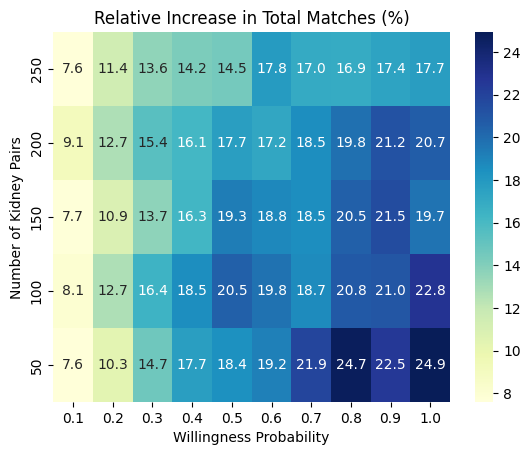

In [ ]:
pivot_rel = df_rel.pivot_table(index="n_kidney", columns="willing_prob", values="relative_increase")
pivot_abs = df_abs.pivot_table(index="n_kidney", columns="willing_prob", values="absolute_increase")
pivot_base = df_base.pivot_table(index="n_kidney", columns="willing_prob", values="abs matches")
pivot_int = df_int.pivot_table(index="n_kidney", columns="willing_prob", values="abs matches")

plt.figure()
sns.heatmap(pivot_rel, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Relative Increase in Total Matches (%)")
plt.xlabel("Willingness Probability")
plt.ylabel("Number of Kidney Pairs")
plt.gca().invert_yaxis()

plt.savefig("rel_incr.pdf", format="pdf", bbox_inches="tight")
plt.show()

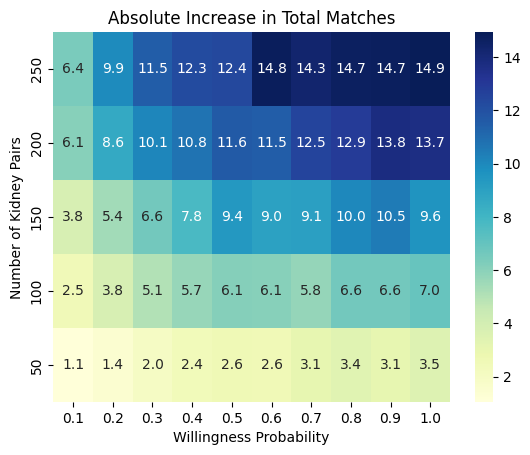

In [ ]:
plt.figure()
sns.heatmap(pivot_abs, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Absolute Increase in Total Matches")
plt.gca().invert_yaxis()
plt.xlabel("Willingness Probability")
plt.ylabel("Number of Kidney Pairs")

plt.savefig("abs_incr.pdf", format="pdf", bbox_inches="tight")
plt.show()